[[0 1 0 1 0 1 0 1]
 [0 0 1 1 0 0 1 1]
 [0 0 0 0 1 1 1 1]]
[[ 707 -707  960 9600]
 [ 707  707  540 5400]
 [   0    0    1   10]]
[960. 540.], [1030.71  610.71], [889.29 610.71], [960.   681.42], [960. 540.], [1024.28  604.28], [895.72 604.28], [960.   668.56], P_exact:
[[707.11 -707.11 960.0 9600.0]
 [707.11 707.11 540.0 5400.0]
 [0.0 0.0 1.0 10.0]
P estimated using normalized points
[[707.11 -707.11 960.0 9600.0]
 [707.11 707.11 540.0 5400.0]
 [-0.0 0.0 1.0 10.0]
P estimated using raw points
[[707.11 -707.11 960.0 9600.0]
 [707.11 707.11 540.0 5400.0]
 [0.0 -0.0 1.0 10.0]
[960. 540.], [1030.71  610.71], [889.29 610.71], [960.   681.42], [960. 540.], [1024.28  604.28], [895.72 604.28], [960.   668.56], 
---------------------------------------------
[960. 540.], [1030.71  610.71], [889.29 610.71], [960.   681.42], [960. 540.], [1024.28  604.28], [895.72 604.28], [960.   668.56], 
---------------------------------------------
[960. 540.], [1030.71  610.71], [889.29 610.71], [960.   681.42

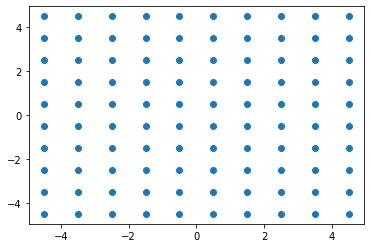

C:\Users\henri\AppData\Local\Temp\ipykernel_7544\2705274580.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


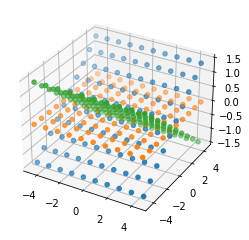

[[[ -41   21 -556]
  [ -41  -48 -313]
  [   0    0    0]]

 [[ -41   41 -554]
  [ -41  -41 -311]
  [   0    0    0]]

 [[ -41   56 -556]
  [ -41  -29 -313]
  [   0    0    0]]]
Relative error: -1.444374134185189e-15
Relative error: -2.361446541782053e-15
Relative error: -1.1121745885356304e-15
[ 0.00000045  0.          0.00000045 -0.00043376 -0.00024399  0.99999988]
Relative Error 2.8056052293936012e-18
B
------------------------------- 
 [[ 0.000001  0.       -0.00096 ]
 [ 0.        0.000001 -0.00054 ]
 [-0.00096  -0.00054   2.2132  ]]
B_true:
-------------------------------
 [[ 0.000001  0.       -0.00096 ]
 [ 0.        0.000001 -0.00054 ]
 [-0.00096  -0.00054   2.2132  ]]
lambda: 0.45183439190302954
[[1000    0  960]
 [   0 1000  539]
 [   0    0    1]]
[[1000    0  960]
 [   0 1000  540]
 [   0    0    1]]
Lmabda1, Lambda2:  17.15190869235849 17.14834458700471
DIFF 0.0035641053537780465 
---------------------
Lmabda1, Lambda2:  17.22921969015791 17.229219690157905
DIFF 7.1054273576

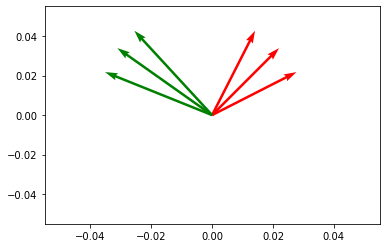

Estimated t for each plane.
[[0.         0.00994729 9.94729463]
 [0.         0.00994729 9.94729463]
 [0.         0.00994729 9.94729463]]
Real t
[[ 0  0 10]]


In [105]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.optimize as coolNonLinOptimizer
%run ex4.ipynb

# Exercise 5

These exercises will take you through: \ 
1. non-linear optimization, where you will implement a non-linear triangulation
2. checkerboard calibration, in real life with OpenCV.


## Nonlinear optimization
This exercise will take you through doing nonlinear optimization for triangulation of a single \
point. The same principles can be applied to more complex situations such as camera calibration, \
or situations where we lack a linear algoritm.


In [106]:
### Construct two camera matrices
R1 = np.identity(3)
R2 = np.identity(3)
t1 = np.array([[0, 0, 1]]).T
t2 = np.array([[0, 0, 20]]).T

K1 = np.array([[700, 0, 600], [0, 700, 400], [0, 0, 1]])
K2 = np.array([[700, 0, 600], [0, 700, 400], [0, 0, 1]])

In [107]:
### Both cameras observe the 3D point Q
Q = np.array([[1, 1, 0]]).T
Qh = np.vstack((Q, np.ones(len(Q[0]))))

### 5.1 Projection matrices

In [108]:
### 
P1 = K1@np.hstack((R1, t1))
P2 = K2@np.hstack((R2, t2))

### Projections
q1h = P1 @ Qh
q2h = P2 @ Qh
### Inhomogenous coordinates
q1 = q1h[0:2, :]/q1h[2, :]
q2 = q2h[0:2, :]/q2h[2, :]

In [109]:
print(q1,"\n", q2)

[[1300.]
 [1100.]] 
 [[635.]
 [435.]]


### 5.2 Simulated noise

In [110]:
q1_noisy = q1 + np.array([[1, -1]]).T
q2_noisy = q2 + np.array([[1, -1]]).T

Imported helper functions

In [111]:
def projectpoints(K, R, t, Q):
    """
    Projects 3D points of an object to the 2D image plane of the camera.
    Using homogenous coordinates the process can be done like this:
            p_h = K*[R t]*P_h

    Parameters:
        - K: camera matrix - hold intrinsic camera info like focault distance and principal points
        - R, t: pose of camera transformation; scale and transport object to the camera plane.
        - Q: 3xn the n 3D points to be projected onto image plane.
    
    Returns: 2xn matrix of projected points
    """
    
    # First creates the [R t] Matrix
    A = np.hstack((R, t))
    # Then, translate Q to homogenous plane => 4xn matrix by adding s=1
    B = np.vstack((Q, np.ones(len(Q[0]))))
    # Solve the projection in homogenous plane 
    p_h = K@A@B
    # Translate back to cartesian coordinates and return (divide all by s, then remove s)
    return p_h[0:2, :]/p_h[2, :]

def triangulate(q, P):
    """
    Return the traingulation.
    
    Parameters
    ----------
    q: 2 x n numpy array
        INHomogenous pixel coordinates q1... qn
        One for each camera seeing the point.
        At least two.
    P: list of 3 x 4 numpy arrays
        Projection matrices P1... Pn
        For each pixel coordinate
    
    Return
    ------
    Q: 3 x 1 numpy array
        Triangulation of the point using the linear SVD algorithm
    """
    _, n = q.shape # n = no. cameras has seen pixel.

    # Prepare B matrix. Two rows for each camera n.
    B = np.zeros((2 * n, 4))
    for i in range(n):
        B[2 * i: 2 * i + 2] = [
            P[i][2, :] * q[0, i] - P[i][0, :],
            P[i][2, :] * q[1, i] - P[i][1, :],
        ]
    # BQ = 0. Minimize using Svd.
    _, _, vh = np.linalg.svd(B)
    Q = vh[-1, :] # Q is ev. corresponding to the min. singular point.
    return Q[:3].reshape(3, 1) / Q[3] # Reshape and scale.

In [112]:
Q_projected = triangulate(np.hstack((q1_noisy, q2_noisy)), [P1, P2])

In [113]:
print(Q_projected)
print("Error/distance between Q and Q_tilde:", np.linalg.norm(Q-Q_projected))

[[1.01527507]
 [0.98527057]
 [0.00028579]]
Error/distance between Q and Q_tilde: 0.021221817353380575


In [114]:
### Then reproject the points...
Qh_projected  = np.vstack((Q_projected, np.ones(len(Q_projected[0]))))
q1h_reprojected = P1 @ Qh_projected
q2h_reprojected = P2 @ Qh_projected
### Inhomogenous coordinates
q1_reprojected = q1h_reprojected[0:2, :]/q1h_reprojected[2, :]
q2_reprojected = q2h_reprojected[0:2, :]/q2h_reprojected[2, :]

In [115]:
print("Total distance of the noisy points and their reprojected points")
print("Camera1:", np.linalg.norm(q1_reprojected-q1_noisy)," pixels\nCamera2:", np.linalg.norm(q2_reprojected-q2_noisy), "pixels")

Total distance of the noisy points and their reprojected points
Camera1: 13.433018988191378  pixels
Camera2: 0.6717725840473774 pixels


### 5.3 Nonlinear triangulation

We are going to make a new function triangulate_nonlin that does triangulation using nonlinear \
optimization. It should take the same inputs as triangulate, i.e. a list of n pixel coordinates (q1, \
q2, . . . , qn), and a list of n projection matrices (P1, P2, . . . , Pn). 

Start by defining a helper-function inside triangulate_nonlin. \
This function, called compute_residuals, should take the parameters we want to optimize (in \
this case Q) as input, and should returns a vector of residuals (i.e. the numbers that we want to \
minimize the sum of squares of).

In [116]:
def triangulate_nonlin(q, P):
    """
    Return the traingulation using nonlinear optimization.
    
    Parameters
    ----------
    q: 2 x n numpy array
        INHomogenous pixel coordinates q1... qn
        One for each camera seeing the point.
        At least two.
    P: list of 3 x 4 numpy arrays
        Projection matrices P1... Pn
        For each pixel coordinate
    
    Return
    ------
    Q: 3 x 1 numpy array
        Triangulation of the point using the linear SVD algorithm,
        combined with least square omptimizer
    """
    # Initial guess using SVD
    Q0 = triangulate(q, P)
    Q0 = Q0.reshape(3)
    
    def compute_residuals(Q):
        """
        In our case residuals is a vector of differences in the projections.
        """
        Qh = np.vstack((Q.reshape(3,1), 1))
        # n cameras
        n = len(q[0])
        residuals = np.zeros(shape=(2*n,))

        for i in range(n):
            qh_est = P[i] @ Qh
            q_est = qh_est[0:2, :]/qh_est[2, :]
            r = q_est - q[:,i].reshape(2, 1)

            residuals[2*i] = r[0]
            residuals[2*i+1] = r[1]


        return residuals
    Q = coolNonLinOptimizer.least_squares(compute_residuals, Q0)["x"].reshape(3,1)
    return  Q


### 5.4 Testing

In [117]:
Q_nonlin = triangulate_nonlin(np.hstack((q1_noisy, q2_noisy)), [P1, P2])

In [118]:
print("Using only linear method:",Q_projected.flatten())
print("Using nonlinear methods:", Q_nonlin.flatten())
print("Real Q:", Q.flatten())
print("Q_nonlin difference: ",  np.linalg.norm(Q_nonlin-Q))
print("Q_linear difference: ",  np.linalg.norm(Q_projected-Q))


Using only linear method: [1.01527507 0.98527057 0.00028579]
Using nonlinear methods: [1.00153898 0.99854632 0.00004275]
Real Q: [1 1 0]
Q_nonlin difference:  0.0021174154572877386
Q_linear difference:  0.021221817353380575


**WOW** That is about 10 times better using the nonlinear optimizer together with linear SVD optimizer.

### Camera calibration using openCV

In the following exercises you will be calibrating your own camera. For this we suggest using a camera in your phone or similar. \
Disable HDR on your phone. If you have a phone with a wide angle camera, consider using this camera for the exercise (as more \
lens distortion is more fun and challenging). Remember to disable lens correction in your camera app before taking the pictures. \
If you get stuck with the OpenCV functions, start by looking it up in the OpenCV documentation.


### 5.5 Calibration target

Take one of the provided calibration targets or print your own. If you do not have access to a printer, \
showing the target on a laptop or tablet display is also an option, albeit less ideal due to the glass on top of the display, \
which can cause reflection and refraction. Using your calibration target, take pictures of it from many different angles. \
Make sure to have an image of it straight on and well lit, and try more extreme angles as well. Try to get every part \
of the frame covered. You should have around twenty images.


#### 5.6 Load and process images

In [157]:
def get_rgb(path):
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)       # get b,g,r
    image = cv2.merge([r,g,b])
    return image


In [158]:
images = []
for i in range(20):
    image = get_rgb("checkerboard/c%02d.jpg" %i)
    image = cv2.resize(image, (600, 400))
    images.append(image)

In [159]:
########################
## Chessboard corners ##
########################
imgpoints = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7, 10))
    if ret == True:
        imgpoints.append(corners)
        # Draw and display the corners
        #painted = cv2.drawChessboardCorners(img.copy(), (7, 10), corners,ret)
        #cv2.imshow('img',painted)
        #cv2.waitKey(400)

#cv2.destroyAllWindows()

#### 5.7 Camera calibration I

Checkerboard model. Construct the points on the checkerboard in 3D. \
This is done using last weeks exercise. The board is assumed to be on z = 0.

shape: (3, 70)


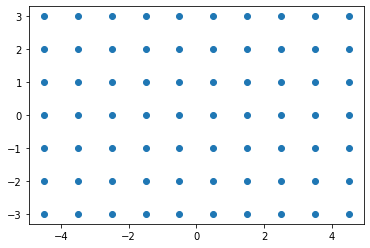

In [211]:
######################
## Chessboard model ##
######################
def checkerboard_points(n,m):
    Q = np.zeros(shape=(3, n*m))
    for i in range(n):
        for j in range(m):
            Q[:, i*m+j] = [i - (n-1)/2.0,
                        j - (m-1)/2.0,
                        0]
                
    return Q

checkerboard = checkerboard_points(10,7)
print("shape:", checkerboard.shape)
plt.scatter(checkerboard[0,:], checkerboard[1,:])

**Now** Either calibratecamera(qs, Q) from last week, or cv2's built in calibratecamera to calibrate the camera.


In [212]:
qs = []
for i in range(len(imgpoints)):    
    r, _, c = imgpoints[i].shape
    q_ = np.zeros(shape=(c, r))
    q_[0, :] = imgpoints[i][:,0,0]
    q_[1, :] = imgpoints[i][:,0,1]
    qs.append(q_)

In [213]:
############
# Homemade #
############ 
print(qs[0].shape)
print(checkerboard.shape)
K_homemade, Rs_homemade, ts_homemade = calibratecamera(qs, checkerboard, verbose=False)

(2, 70)
(3, 70)


In [214]:
K_homemade#, ts

array([[ 693.37827726, -142.6841463 ,  380.68691743],
       [   0.        ,  564.80927065,  194.24722869],
       [   0.        ,    0.        ,    1.        ]])

**Problem** the R might not work? (yes it does, see further down)

The K should be good however!

In [215]:
objpoints = [np.float32(checkerboard.T)]
while len(objpoints)<len(imgpoints):
    objpoints.append(np.float32(checkerboard.T))
print(checkerboard[:,0])
print(objpoints[0][0])

[-4.5 -3.   0. ]
[-4.5 -3.   0. ]


In [216]:
print(objpoints[0].shape)
print(imgpoints[0].shape)
print(type(objpoints[0][0, 0]))
len(imgpoints)==len(objpoints)

(70, 3)
(70, 1, 2)
<class 'numpy.float32'>


True

In [321]:
############
# Built in #
############

ret, K_cv2, distortion_coefficients, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None, 
        flags = cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+
        cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6+cv2.CALIB_ZERO_TANGENT_DIST
    )

#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("Distortion is set to 0, so d-vector will be zeroes:", distortion_coefficients)
np.asarray(tvecs).shape

Distortion is set to 0, so d-vector will be zeroes: [[0. 0. 0. 0. 0.]]


(17, 3, 1)

In [322]:
K_cv2, K_homemade

(array([[785.09535588,   0.        , 317.8037071 ],
        [  0.        , 635.94333856,  68.32166874],
        [  0.        ,   0.        ,   1.        ]]),
 array([[ 693.37827726, -142.6841463 ,  380.68691743],
        [   0.        ,  564.80927065,  194.24722869],
        [   0.        ,    0.        ,    1.        ]]))

#### 5.8 ReProject the points

Reproject the checkerboard corners to the images. \
**NB**: cv2.calibrateCamera returns rvecs, which are the R matrices stored in axis-angle representation. You can convert them to rotation matrices with cv2.Rodrigues.

In [323]:
Rs_cv2 = []
for rvec in rvecs:
    R, _ = cv2.Rodrigues(rvec)
    Rs_cv2.append(R)

ts_cv2 = np.asarray(tvecs)

In [324]:
print(np.asarray(ts_homemade)[0].reshape(3,1).shape)
print(ts_cv2[0].shape)

(3, 1)
(3, 1)


In [325]:
i = 0
reprojection_boards_cv2 = []
reprojection_boards_homemade = []

qs_cv2 = []
qs_homemade = []

for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7, 10))
    if ret == True:
        # Make copies to draw on
        cpy_cv2 = img.copy()
        cpy_homemade = img.copy()
        # Projection matrices
        P_cv2       = K_cv2         @   np.hstack((Rs_cv2[i], ts_cv2[i]))
        P_homemade  = K_homemade    @   np.hstack((Rs_homemade[i], ts_homemade[i].reshape(3,1)))
        # Project
        qh_cv2 = P_cv2 @ np.vstack((checkerboard, np.ones(len(checkerboard[0]))))
        qh_homemade = P_homemade @ np.vstack((checkerboard, np.ones(len(checkerboard[0]))))
        # Inhomogenous coordinates
        q_cv2 = qh_cv2[0:2, :]/qh_cv2[2, :]
        q_homemade = qh_homemade[0:2, :]/qh_homemade[2, :]
        qs_cv2.append(q_cv2)
        qs_homemade.append(q_homemade)
        # Draw all points onto images
        for k in range(len(q_cv2[0])):
            # Using cv2 built in
            row = int(q_cv2[0,k])
            col = int(q_cv2[1,k])
            cv2.circle(img=cpy_cv2, center=(row, col), radius =1, color =(255,0,0), thickness=4)
            # Using homemade
            row = int(q_homemade[0,k])
            col = int(q_homemade[1,k])
            cv2.circle(img=cpy_homemade, center=(row, col), radius =1, color =(255,0,0), thickness=4)

        reprojection_boards_cv2.append(cpy_cv2)
        reprojection_boards_homemade.append(cpy_homemade)

        i+=1

**WOW** It seems the homemade calibration is a also working despite the doubts from last week!

Text(0.5, 1.0, 'Homemade')

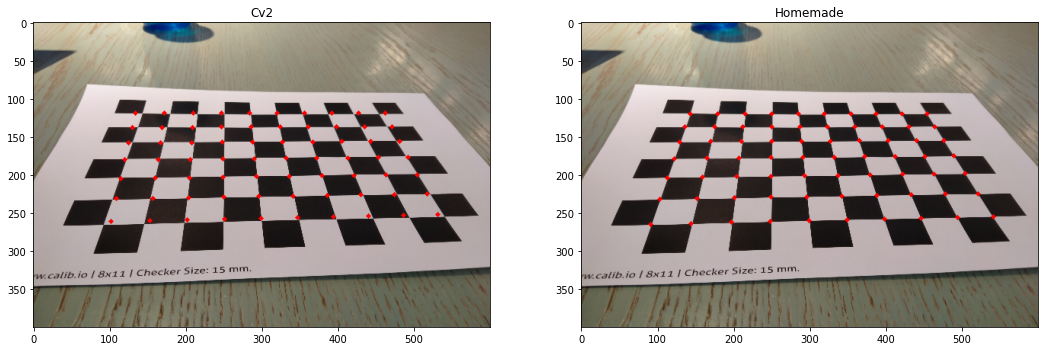

In [326]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(reprojection_boards_cv2[7])
ax[0].set_title('Cv2')
ax[1].imshow(reprojection_boards_homemade[7])
ax[1].set_title('Homemade')

**Calculate reprojection error** by comparing detected vs projected corners.

In [288]:
######################################################################################
### qs holds all detected corners, while qs_homemade holds all reprojected points. ###
######################################################################################
RMSEs = np.zeros(len(qs))
for i in range(len(qs)):
    RMSE = np.sqrt(np.mean((qs[i]-qs_homemade[i])**2))
    RMSEs[i] = RMSE

In [293]:
print("Our biggest error is to be found in image no.", RMSEs.argmax()+1)
print("The RMSE value of this image is", RMSEs.max())

Our biggest error is to be found in image no. 16
The RMSE value of this image is 0.8055655386444789


In [298]:
#####################################
## First draw the detected corners ##
#####################################
detected_drawings = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7, 10))
    if ret == True:
        # Draw style 1
        painted = cv2.drawChessboardCorners(img.copy(), (7, 10), corners,ret)
        detected_drawings.append(painted)

Text(0.5, 1.0, 'Reprojected point')

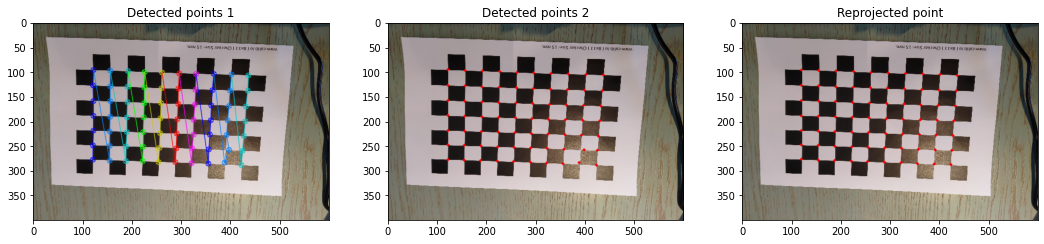

In [308]:
###########################################
## Alternatively just use qs from before ##
###########################################
points = qs[RMSEs.argmax()]
painted_2 = images[18].copy()
for i in range(len(points[0])):
    row = int(points[0,i])
    col = int(points[1,i])
    cv2.circle(img=painted_2, center=(row, col), radius =1, color =(255,0,0), thickness=4)

#######################
## Then compare them ##
#######################

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,18))
ax[0].imshow(detected_drawings[RMSEs.argmax()])
ax[0].set_title('Detected points 1')
ax[1].imshow(painted_2)
ax[1].set_title('Detected points 2')
ax[2].imshow(reprojection_boards_homemade[RMSEs.argmax()])
ax[2].set_title('Projected point')

**So** what is happening here?
- The reprojected points are relying on the checkerboard model "Q": which contains exact checkerboard coordinates.
- The detection algorithm struggles to find the exact corners, du to the reflection on the paper.
- Therefore, the projected point hits the corners "more accurate" than the detection algorithm!

But don't we use the badly detected corners to calibrate in the first place? Yes we do! But this becomes less and less of a problem when we have enough pictures to use.

#### 5.9 Change distortion model 

We saw that the built in CV2 model was not impressing anyone in the test above. Try to make it more precise by including two distortion coefficients and see if that will increase its precision.

In [327]:
ret, K_cv2, distortion_coefficients, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None, 
        flags = cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+
        cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6+cv2.CALIB_ZERO_TANGENT_DIST
    )

Rs_cv2 = []
for rvec in rvecs:
    R, _ = cv2.Rodrigues(rvec)
    Rs_cv2.append(R)

ts_cv2 = np.asarray(tvecs)

In [328]:
i = 0
reprojection_boards_cv2_v2 = []

qs_cv2_v2 = []

for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7, 10))
    if ret == True:
        # Make copies to draw on
        cpy_cv2 = img.copy()
        # Projection matrices
        P_cv2       = K_cv2         @   np.hstack((Rs_cv2[i], ts_cv2[i]))
        # Project
        qh_cv2 = P_cv2 @ np.vstack((checkerboard, np.ones(len(checkerboard[0]))))
        # Inhomogenous coordinates
        q_cv2 = qh_cv2[0:2, :]/qh_cv2[2, :]
        qs_cv2_v2.append(q_cv2)
        # Draw all points onto images
        for k in range(len(q_cv2[0])):
            # Using cv2 built in
            row = int(q_cv2[0,k])
            col = int(q_cv2[1,k])
            cv2.circle(img=cpy_cv2, center=(row, col), radius =1, color =(255,0,0), thickness=4)

        reprojection_boards_cv2_v2.append(cpy_cv2)

        i+=1

Text(0.5, 1.0, 'Cv2 ver 2')

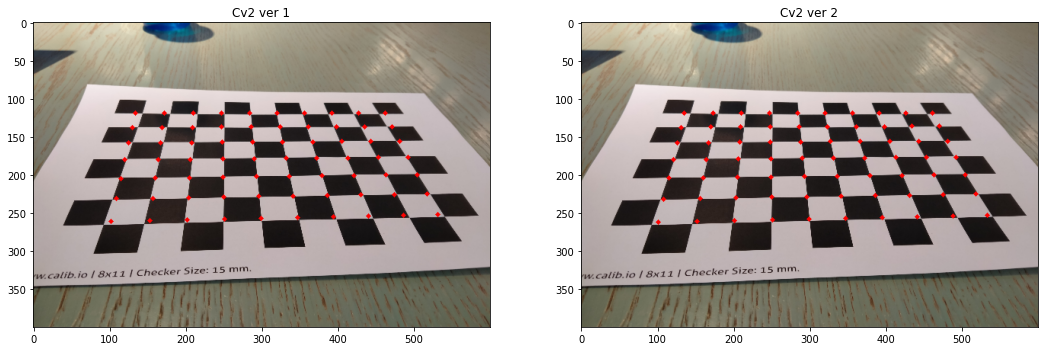

In [329]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(reprojection_boards_cv2[7])
ax[0].set_title('Cv2 ver 1')
ax[1].imshow(reprojection_boards_cv2_v2[7])
ax[1].set_title('Cv2 ver 2')

**It doesnt seem like distortion is the only problem here...**

I will stick to my homemade stew